In [3]:
import os
import re
import pickle
import random
import shutil
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import SVG
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Embedding, Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Masking
from keras.models import Model, load_model, Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


%matplotlib inline

In [4]:
N_CLASSES = 2

In [28]:

df = pd.read_csv('data/train.csv', usecols=['text', 'target'])\
  .rename(columns={'text': 'x', 'target': 'y'})
test_df = pd.read_csv('data/test.csv', usecols=['text'])\
  .rename(columns={'text': 'x'})

In [29]:
train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df['y'], random_state=42)
train_texts = train_df['x']
valid_texts = valid_df['x']
test_texts = test_df['x']

In [7]:
train_targets = train_df['y']
valid_targets = valid_df['y']


In [8]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(train_targets)
y_valid = label_encoder.transform(valid_targets)

y_train_1_hot = to_categorical(y_train, N_CLASSES)
y_valid_1_hot = to_categorical(y_valid, N_CLASSES)

with open('label_encoder.p', 'wb') as f:
    pickle.dump(label_encoder, f)

In [9]:
print(y_train_1_hot)
print(y_train_1_hot.shape)
print(y_valid_1_hot)
print(y_valid_1_hot.shape)

[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
(6090, 2)
[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]
(1523, 2)


In [35]:
NUM_WORDS = 10000

tokenizer = Tokenizer(NUM_WORDS)
tokenizer.fit_on_texts(train_texts)
NUM_WORDS = min(NUM_WORDS, len(tokenizer.word_index))
print('Actual NUM_WORDS={}'.format(NUM_WORDS))

with open('tokenizer.p', 'wb') as f:
    pickle.dump(tokenizer, f)

train_texts_encoded = tokenizer.texts_to_sequences(train_texts)
valid_texts_encoded = tokenizer.texts_to_sequences(valid_texts)
test_texts_encoded = tokenizer.texts_to_sequences(test_texts)

Actual NUM_WORDS=10000


In [11]:
train_text_lengths = list(map(len, train_texts_encoded))
pd.Series(train_text_lengths).describe()

count    6090.000000
mean       15.299507
std         5.807127
min         0.000000
25%        11.000000
50%        16.000000
75%        20.000000
max        33.000000
dtype: float64

In [36]:
MAX_SEQUENCE_LENGTH = 25

X_train = pad_sequences(train_texts_encoded, MAX_SEQUENCE_LENGTH)
X_valid = pad_sequences(valid_texts_encoded, MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(test_texts_encoded, MAX_SEQUENCE_LENGTH)

In [13]:
def get_one(i, size):
    """
    >>> get_one(3, 8)
    array([False, False, False,  True, False, False, False, False])
    """
    return np.eye(1, size, k=i, dtype=np.bool).ravel()


def encode_texts(texts):
    # max_sentence_len = np.max(list(map(len, texts)))
    # X = np.zeros((len(texts), max_sentence_len, NUM_WORDS), dtype=np.int8)
    X = np.zeros((len(texts), MAX_SEQUENCE_LENGTH, NUM_WORDS), dtype=np.int8)
    
    for i, text in enumerate(texts):
        for t, word_id in enumerate(text):
            X[i, t, :] = get_one(word_id, NUM_WORDS)
            
    return X


def iter_batches(texts, targets=None, batch_size=16, sort_by_len=True, shuffle=True):
    assert batch_size > 0
    
    if sort_by_len:
        text_lengths = list(map(len, texts))
        indexes = np.argsort(text_lengths)

        texts = np.array(texts)[indexes]

        if targets is not None:
            targets = np.array(targets)[indexes]
    
    batch_indexes = list(range(len(texts) // batch_size))
    
    while True:
        if shuffle:
            random.shuffle(batch_indexes)
            
        for i in batch_indexes:
            texts_batch = texts[i * batch_size:(i + 1) * batch_size]
            texts_batch_encoded = encode_texts(texts_batch)
            
            if targets is not None:
                targets_batch = targets[i * batch_size:(i + 1) * batch_size]
                yield texts_batch_encoded, targets_batch
            else:
                yield texts_batch_encoded


In [14]:
model = Sequential([
    Masking(mask_value=np.int8(0), input_shape=(None, NUM_WORDS)),
    LSTM(units=16, activation='tanh'),
    Dense(N_CLASSES, activation='softmax')
])


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(clipnorm=1.),
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
from keras.callbacks import CSVLogger

In [18]:
shutil.rmtree('checkpoints', ignore_errors=True)
os.makedirs('checkpoints', exist_ok=True)

BATCH_SIZE = 16

train_gen = iter_batches(X_train, y_train_1_hot, BATCH_SIZE)
test_gen = iter_batches(X_test, batch_size=BATCH_SIZE, sort_by_len=False)
valid_gen = iter_batches(X_valid, y_valid_1_hot, BATCH_SIZE)



checkpointer = ModelCheckpoint('checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5')
stopper = EarlyStopping(patience=3)

history = model.fit_generator(train_gen,
                              steps_per_epoch=len(train_texts) // BATCH_SIZE,
                              validation_data=valid_gen, 
                              validation_steps=len(valid_texts) // BATCH_SIZE,
                              workers=3,
                              use_multiprocessing=True,
                              initial_epoch=30,
                              epochs=40,
                              callbacks=[checkpointer, stopper])


Epoch 31/40


/home/alex/.local/lib/python3.7/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


380/380 [==============================] - 17s 45ms/step - loss: 0.5466 - accuracy: 0.7262 - val_loss: 0.7438 - val_accuracy: 0.7724
Epoch 32/40
380/380 [==============================] - 17s 45ms/step - loss: 0.3722 - accuracy: 0.8462 - val_loss: 0.6345 - val_accuracy: 0.7855
Epoch 33/40
380/380 [==============================] - 18s 48ms/step - loss: 0.2917 - accuracy: 0.8842 - val_loss: 0.8745 - val_accuracy: 0.7875
Epoch 34/40
380/380 [==============================] - 19s 50ms/step - loss: 0.2033 - accuracy: 0.9270 - val_loss: 0.5252 - val_accuracy: 0.8204
Epoch 35/40
380/380 [==============================] - 19s 49ms/step - loss: 0.1846 - accuracy: 0.9326 - val_loss: 0.7331 - val_accuracy: 0.7586
Epoch 36/40
380/380 [==============================] - 18s 48ms/step - loss: 0.1711 - accuracy: 0.9398 - val_loss: 1.2958 - val_accuracy: 0.7862
Epoch 37/40
380/380 [==============================] - 19s 49ms/step - loss: 0.1220 - accuracy: 0.9610 - val_loss: 1.7086 - val_accuracy: 0.78

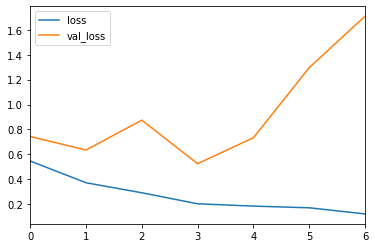

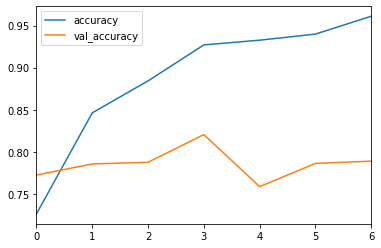

In [21]:
df = pd.DataFrame(history.history)
df.describe()

df[['loss', 'val_loss']].plot()
df[['accuracy', 'val_accuracy']].plot()

In [37]:
test_gen = iter_batches(X_test, batch_size=BATCH_SIZE, sort_by_len=False, shuffle=False)
test_steps = len(X_test) // BATCH_SIZE

y_test_pred_proba = model.predict_generator(test_gen, test_steps)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

In [38]:
print(y_test_pred_proba)

[[9.4033074e-01 5.9669282e-02]
 [2.9942336e-02 9.7005773e-01]
 [9.4446476e-04 9.9905556e-01]
 ...
 [1.8742648e-03 9.9812573e-01]
 [2.0141155e-02 9.7985888e-01]
 [2.0141155e-02 9.7985888e-01]]


In [39]:
print(y_test_pred)
print(y_test_pred.shape)
print(X_test.shape)

[0 1 1 ... 1 1 1]
(3264,)
(3264, 25)


In [48]:
y_test_pred_col = y_test_pred.reshape(-1, 1)[0:3263]
print(y_test_pred_col)
print(y_test_pred_col.shape)

[[0]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]
(3263, 1)


In [49]:
sample_submission = pd.read_csv("data/sample_submission.csv")
print(sample_submission.shape)
sample_submission["target"] = y_test_pred_col

(3263, 2)


In [50]:
sample_submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [51]:
sample_submission.to_csv("submissions/04_lstm_submission.csv", index=False)

Score: 0.76380

TODO:
  - More advanced LSTM with Embeddings
